In [ ]:
!pip install spacy pandas matplotlib seaborn bertopic[flair] sentence-transformers
!python -m spacy download da_core_news_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=4421fdb20771aca5080ed3ab

In [ ]:
# Step 0.1: Imports and constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from collections import Counter

# Embedding & clustering
from umap import UMAP
from sklearn.cluster import KMeans
import hdbscan
from sentence_transformers import SentenceTransformer


# NLP
import spacy

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

sns.set(style="whitegrid")


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Load embeddings from disk without loading all into RAM
embeddings = np.load('/content/drive/MyDrive/01_embeddings.npy', mmap_mode='r')
print("Embeddings shape (memory-mapped):", embeddings.shape)





Mounted at /content/drive
Embeddings shape (memory-mapped): (1200456, 768)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/danishnews.csv')

In [ ]:
df.head()

,plain_text,published_date,title,tags,categories,author,sitename,publisher
0,1.200 danske vinavlere har haft en sensationel...,2016-10-22,1.200 danske vinavlere har haft en sensationel...,NaN,NaN,Guldborgsundavis Dk,www.guldborgsundavis.dk,guldborgsundavis.dk
1,"Ung i krise Frihed, styrke og uendelig appeti...",2016-10-21,Sara blev psykisk syg som ung: Nu havde jeg ik...,"Skizofreni, psykisk sygdom, psykiske lidelser",Liv & Sjæl,Ung i krise Af Thilde Thordahl Andersen,Kristeligt Dagblad,kristeligt-dagblad.dk
2,Hvis livslængden øges i samme tempo i yderlige...,2016-10-20,Det meget lange liv er både fascinerende og sk...,"alder, aldring, Tid, udvikling, sundhed",Liv & Sjæl,Boguddrag Kaare Christensen; Professor Og Aldr...,Kristeligt Dagblad,kristeligt-dagblad.dk
3,Læs også relevante temaer Den republikanske ...,2016-10-20,Trump chokerer i tv-debat,"Trump, Clinton, præsidentvalg",Udland,Af Sidsel Nyholm; Korrespondent; USA,Kristeligt Dagblad,kristeligt-dagblad.dk
4,Læs også Hvorfor skifter bladene farve? Hvorn...,2016-10-20,Test din viden om efteråret,"efterår, Quiz, blade, trækfugl",Quiz,Efterårsquiz Af Rasmus Fahrendorff,Kristeligt Dagblad,kristeligt-dagblad.dk


In [ ]:
df.isna().mean().sort_values(ascending=False)


,0
tags,0.736428
categories,0.528103
author,0.100604
plain_text,0.000000
title,0.000000
published_date,0.000000
sitename,0.000000
publisher,0.000000


In [ ]:
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.dropna(subset=['published_date'])


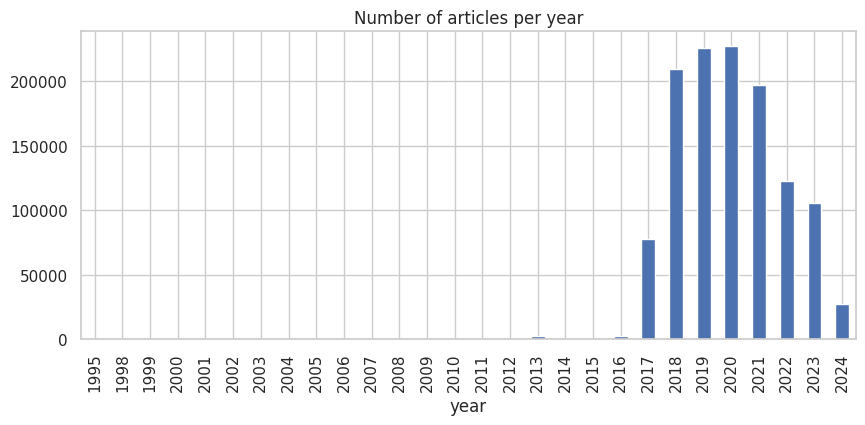

In [ ]:
df['year'] = df['published_date'].dt.year
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(10,4))
plt.title("Number of articles per year")
plt.show()


In [ ]:
AI_KEYWORDS = [
    "ai", "kunstlig intelligens", "artificial intelligence",
    "maskinlæring", "machine learning", "deep learning",
    "neurale netværk", "neural netværk",
    "algoritme", "algoritmer", "generativ ai",
    "chatbot", "chatbotter",
    "robot", "robotter", "robotik", "automatisering",
    "sprogmodel", "store sprogmodeller",
    "computer vision", "billedgenkendelse",
    "ansigtsgenkendelse",
]


In [ ]:
import re

def build_regex(keyword_list):
    escaped = [re.escape(k.lower()) for k in keyword_list]
    return r"(" + r"|".join(escaped) + r")"

AI_PATTERN = build_regex(AI_KEYWORDS)


In [ ]:
df['text_lower'] = df['plain_text'].str.lower()
df['is_ai'] = df['text_lower'].str.contains(AI_PATTERN, regex=True)


/tmp/ipython-input-18065334.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_ai'] = df['text_lower'].str.contains(AI_PATTERN, regex=True)


In [ ]:
ai_counts = df[df['is_ai']].groupby('year').size()
print(ai_counts)


year
2000        2
2001        6
2002        5
2003        1
2004       18
2005        5
2006        4
2007        7
2008       14
2009       18
2010       17
2011       25
2012       16
2013      324
2014       28
2015       48
2016      479
2017    10801
2018    33614
2019    36773
2020    35505
2021    31681
2022    30813
2023    23428
2024     6084
dtype: int64


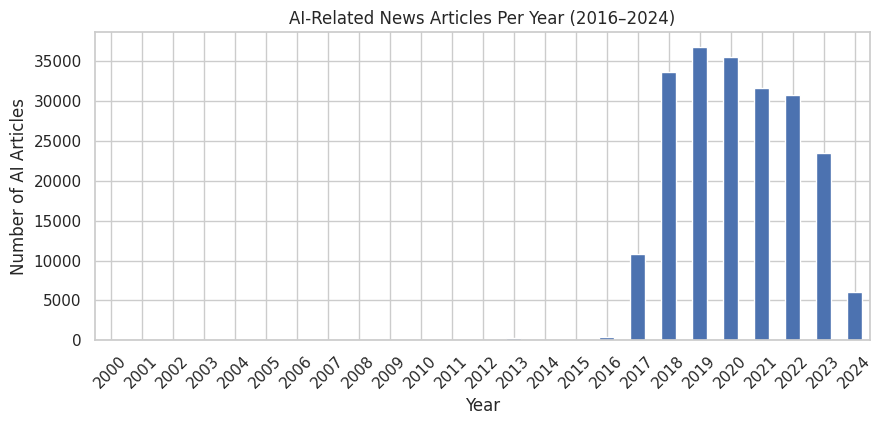

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
ai_counts.plot(kind='bar', title="AI-Related News Articles Per Year (2016–2024)")
plt.xlabel("Year")
plt.ylabel("Number of AI Articles")
plt.xticks(rotation=45)
plt.show()


In [ ]:
publisher_year_counts = df.groupby(['year', 'publisher']).size().reset_index(name='article_count')
publisher_year_counts.head()


,year,publisher,article_count
0,1995,tv2fyn.dk,3
1,1998,tv2fyn.dk,1
2,1999,berlingske.dk,3
3,1999,bt.dk,6
4,1999,philips.dk,1


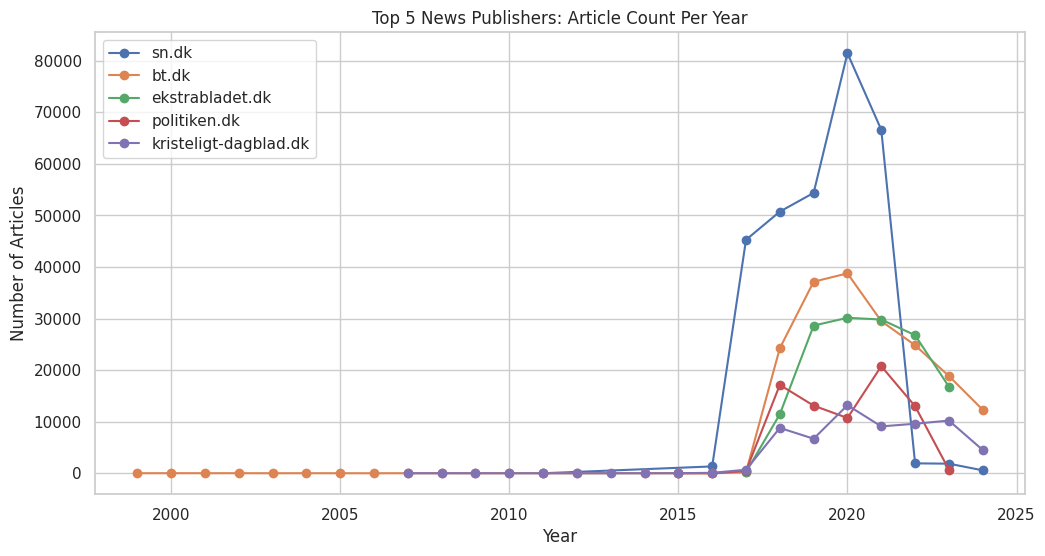

In [ ]:
top_publishers = publisher_year_counts.groupby('publisher')['article_count'].sum().nlargest(5).index

subset = publisher_year_counts[publisher_year_counts['publisher'].isin(top_publishers)]

plt.figure(figsize=(12,6))
for pub in top_publishers:
    yearly = subset[subset['publisher'] == pub]
    plt.plot(yearly['year'], yearly['article_count'], marker='o', label=pub)

plt.title("Top 5 News Publishers: Article Count Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
BARRIERS_KEYWORDS = [
    "manglende data", "datasikkerhed", "privacy", "persondata",
    "lovgivning", "regulering", "compliance", "ai act",
    "ressourcemangel", "kompetencemangel", "dygtige medarbejdere",
    "omkostninger", "høje omkostninger", "teknologisk kompleksitet",
    "mangel på ekspertise", "modstand mod forandring", "etisk bekymring",
    "ansvarlig ai", "algoritmisk bias", "fejl i system", "misinformation",
    "overvågning", "jobtab", "usikkerhed", "risiko", "usikkerhed omkring ai", "resistance", "skills gaps", "data quality", "ethics"
]


In [ ]:
import re

def build_regex(keyword_list):
    escaped = [re.escape(k.lower()) for k in keyword_list]
    return r"(" + r"|".join(escaped) + r")"

BARRIERS_PATTERN = build_regex(BARRIERS_KEYWORDS)

# Lowercase text for matching
df['text_lower'] = df['plain_text'].str.lower()

# Boolean flag: mentions any barrier
df['mentions_barrier'] = df['text_lower'].str.contains(BARRIERS_PATTERN, regex=True)


/tmp/ipython-input-3037921559.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['mentions_barrier'] = df['text_lower'].str.contains(BARRIERS_PATTERN, regex=True)


In [ ]:
barrier_counts = df[df['mentions_barrier']].groupby('year').size()
print(barrier_counts)


year
2000        1
2001        9
2002        5
2004       15
2005        4
2007        2
2008        8
2009        5
2010        7
2011        7
2012       12
2013      204
2014       11
2015       14
2016     1416
2017    48126
2018    65649
2019    68389
2020    97587
2021    78991
2022    10827
2023     9865
2024     2987
dtype: int64


In [ ]:
from collections import Counter

barrier_texts = df[df['mentions_barrier']]['text_lower']
all_words = " ".join(barrier_texts).split()
word_freq = Counter(all_words)

# Show most common barrier-related words
for word, count in word_freq.most_common(30):
    if word in [w.lower() for w in BARRIERS_KEYWORDS]:  # optional filter
        print(word, count)


In [ ]:
import numpy as np

embeddings = np.load('/content/drive/MyDrive/01_embeddings.npy', mmap_mode='r')


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
event_queries = {
    "research_innovation": [
        "AI research", "machine learning research",
        "university AI lab", "deep learning breakthrough",
        "scientific innovation in artificial intelligence"
    ],
    "industry_corporate_adoption": [
        "AI adoption in companies", "enterprise AI",
        "business automation with AI", "corporate AI strategy",
        "AI deployment in industry"
    ],
    "government_policy": [
        "AI public policy", "government AI strategy",
        "national AI regulations", "public sector AI adoption"
    ],
    "ethics_regulation": [
        "AI ethics", "AI regulation",
        "AI safety", "ethical implications of machine learning"
    ],
    "automation_workforce": [
        "job automation", "AI replacing jobs",
        "workforce transformation due to AI"
    ],
    "tech_development": [
        "machine learning model development",
        "AI system design", "neural networks",
        "AI product development"
    ],
    "startups_investment": [
        "AI startup", "venture capital AI investment",
        "AI funding", "AI business ecosystem"
    ],
    "education_skills": [
        "AI skills training", "digital skills",
        "AI education", "upskilling with artificial intelligence"
    ],
    "international_trends": [
        "global AI trends", "international AI development",
        "AI geopolitics", "AI race", "European AI initiatives"
    ]
}


In [ ]:
def embed_queries(query_dict):
    event_vecs = {}
    for evt, phrases in query_dict.items():
        event_vecs[evt] = model.encode(phrases, convert_to_numpy=True, show_progress_bar=False)
    return event_vecs

event_query_vectors = embed_queries(event_queries)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_event_scores(emb_matrix, event_query_vectors, batch_size=5000):
    n = emb_matrix.shape[0]
    results = {evt: [] for evt in event_query_vectors}

    for i in range(0, n, batch_size):
        batch = emb_matrix[i:i+batch_size]

        for evt, qvecs in event_query_vectors.items():
            sims = cosine_similarity(batch, qvecs)
            mean_scores = sims.mean(axis=1)
            results[evt].extend(mean_scores)

        print(f"Processed {i+batch_size:,}/{n:,} rows")

    return results


In [ ]:
event_scores = compute_event_scores(
    emb_matrix=embeddings,
    event_query_vectors=event_query_vectors,
    batch_size=5000
)


Processed 5,000/1,200,456 rows
Processed 10,000/1,200,456 rows
Processed 15,000/1,200,456 rows
Processed 20,000/1,200,456 rows
Processed 25,000/1,200,456 rows
Processed 30,000/1,200,456 rows
Processed 35,000/1,200,456 rows
Processed 40,000/1,200,456 rows
Processed 45,000/1,200,456 rows
Processed 50,000/1,200,456 rows
Processed 55,000/1,200,456 rows
Processed 60,000/1,200,456 rows
Processed 65,000/1,200,456 rows
Processed 70,000/1,200,456 rows
Processed 75,000/1,200,456 rows
Processed 80,000/1,200,456 rows
Processed 85,000/1,200,456 rows
Processed 90,000/1,200,456 rows
Processed 95,000/1,200,456 rows
Processed 100,000/1,200,456 rows
Processed 105,000/1,200,456 rows
Processed 110,000/1,200,456 rows
Processed 115,000/1,200,456 rows
Processed 120,000/1,200,456 rows
Processed 125,000/1,200,456 rows
Processed 130,000/1,200,456 rows
Processed 135,000/1,200,456 rows
Processed 140,000/1,200,456 rows
Processed 145,000/1,200,456 rows
Processed 150,000/1,200,456 rows
Processed 155,000/1,200,456 ro

In [ ]:
for evt, scores in event_scores.items():
    df[f"score_{evt}"] = scores


In [ ]:
event = "industry_corporate_adoption"

df[["title", "plain_text", f"score_{event}"]].sort_values(
    by=f"score_{event}", ascending=False
).head(10)


,title,plain_text,score_industry_corporate_adoption
667548,BMC overtager ComAround,"Overtagelsen kombinerer en markedsførende AI, ...",0.543910
1191337,Kontaktcentre med AI | Intelligent automatiser...,Det er dit kontaktcenter – blot mere intellige...,0.503765
1096175,Her koster robotterne allerede job,"Frygten for, at AI-robotterne koster os jobbet...",0.500553
1175982,AI fremmer kreativ generation: Steve McMillan,MEd den hurtige udvikling af AI og de mulighed...,0.498158
1155764,Apples hemmelige investering i generativ kunst...,I et forsøg på at holde trit med store konkurr...,0.496617
1158869,IBM udvider samarbejdet med Parle-produkter fo...,IBM har annonceret en udvidelse af sit partner...,0.491845
1141741,Chokmelding: Vil erstatte 7800 jobs med robotter,Robotterne kommer! IBM's administrerende direk...,0.486007
1159086,Kan AI overtage klientfeedback?,"Dentsu Creative har udviklet ""The Artificial C...",0.482434
1079349,"Microsoft Stock rammer rekordhøjt, da OpenAI S...",Microsoft-aktien steg til rekordhøje i mandags...,0.481318
759471,Robotten løser de kedelige opgaver,"Der er sindssygt mange lavthængende frugter, s...",0.471793


In [ ]:
df["event_type"] = df[
    [c for c in df.columns if c.startswith("score_")]
].idxmax(axis=1).str.replace("score_", "")


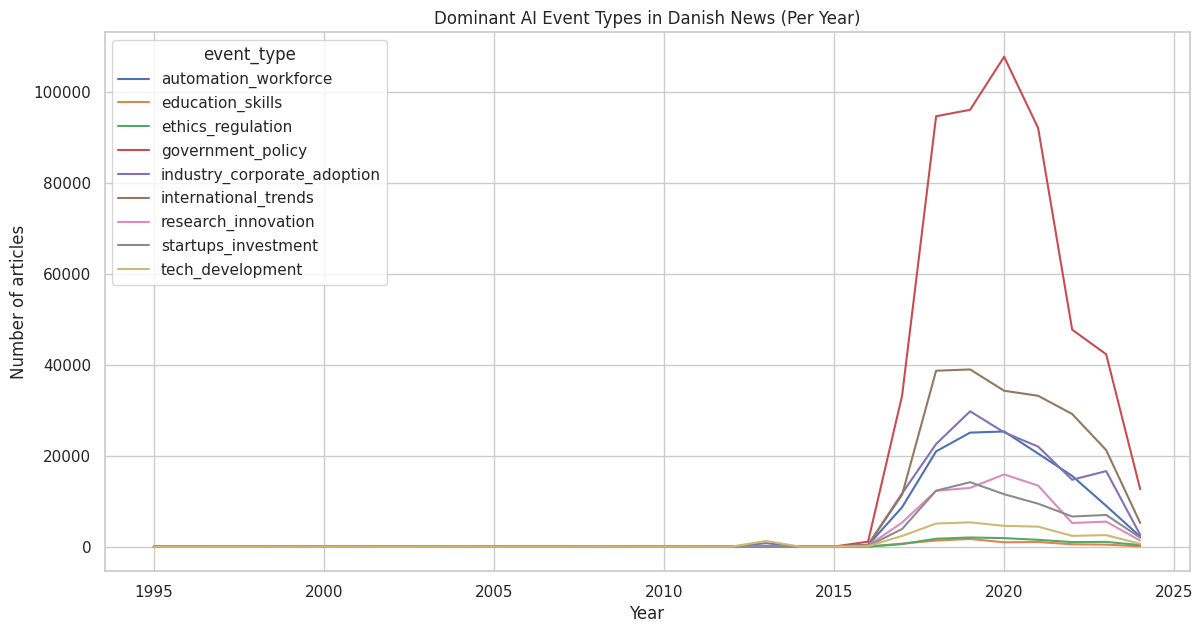

In [ ]:
dominant_counts = df.groupby(["year", "event_type"]).size().unstack(fill_value=0)

dominant_counts.plot(figsize=(14, 7))
plt.title("Dominant AI Event Types in Danish News (Per Year)")
plt.ylabel("Number of articles")
plt.xlabel("Year")
plt.show()


In [ ]:
score_cols = [c for c in df.columns if c.startswith("score_")]

if len(score_cols) == 0:
    print("No columns starting with 'score_' found in df.")
    print("Available columns:", list(df.columns[:50]))
    raise RuntimeError("Compute semantic scores first (see previous pipeline).")
else:
    print(f"Found {len(score_cols)} score columns.")
    print(score_cols)

Found 9 score columns.
['score_research_innovation', 'score_industry_corporate_adoption', 'score_government_policy', 'score_ethics_regulation', 'score_automation_workforce', 'score_tech_development', 'score_startups_investment', 'score_education_skills', 'score_international_trends']


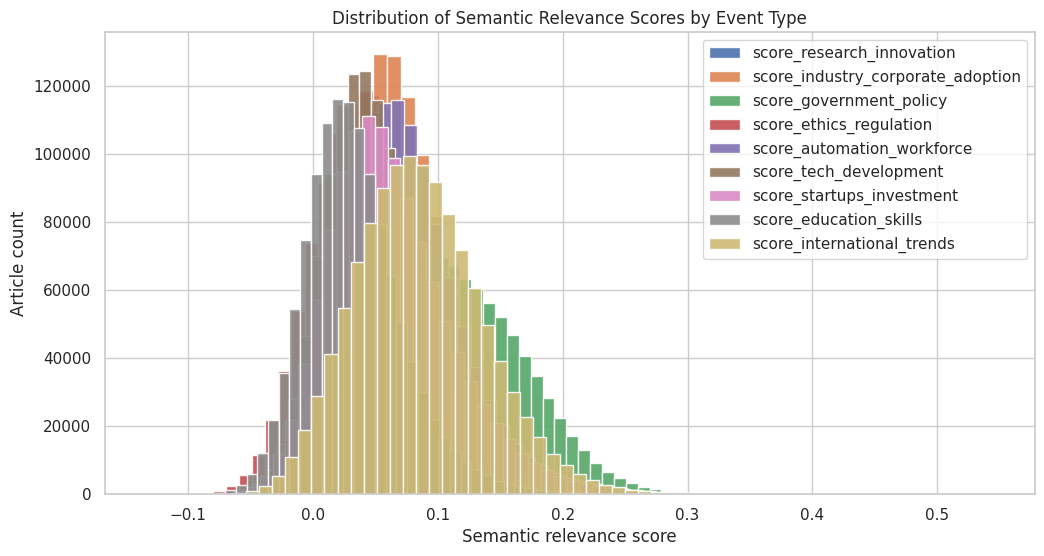

In [ ]:
# Cell 4 — distribution plot of scores (histograms)
plt.figure(figsize=(12,6))
for col in score_cols:
    plt.hist(df[col].dropna(), alpha=0.9, bins=60, label=col)
plt.title("Distribution of Semantic Relevance Scores by Event Type")
plt.xlabel("Semantic relevance score")
plt.ylabel("Article count")
plt.legend(loc='upper right')
plt.show()


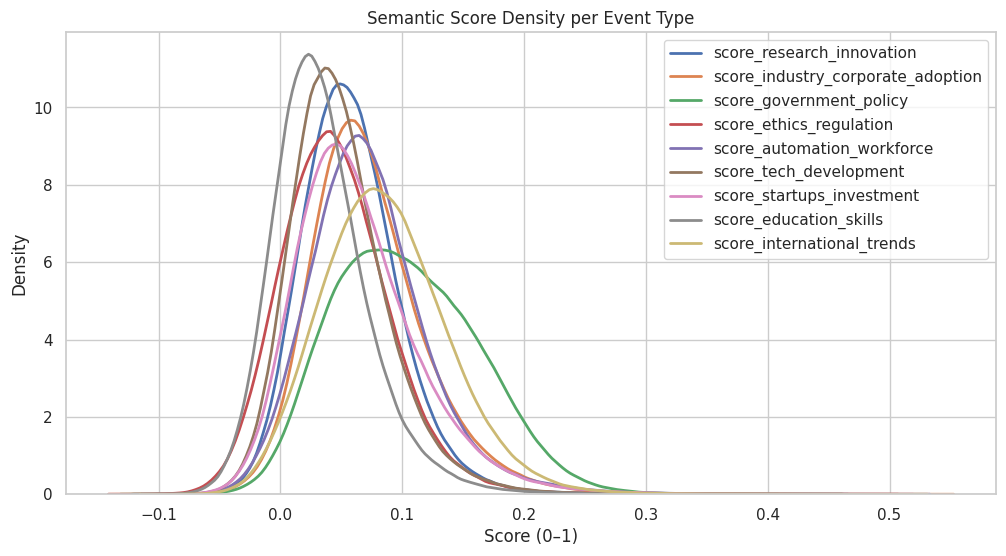

In [ ]:
plt.figure(figsize=(12, 6))

for col in score_cols:
    sns.kdeplot(df[col].dropna(), label=col, linewidth=2)

plt.title("Semantic Score Density per Event Type")
plt.xlabel("Score (0–1)")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()
